In [1]:
import torch

num_gpus = torch.cuda.device_count()
num_cpus = torch.get_num_threads()

print(f"Number of available CPU cores: {num_cpus}")
print(f"Number of available GPUs: {num_gpus}")

Number of available CPU cores: 1
Number of available GPUs: 1


In [2]:
%%capture
!git clone https://github.com/aliabbasi2000/PIDNet.git
%cd /content/PIDNet/

In [3]:
%%capture
!wget https://zenodo.org/record/5706578/files/Train.zip
!wget https://zenodo.org/record/5706578/files/Val.zip
!unzip Train.zip -d ./LoveDA
!unzip Val.zip -d ./LoveDA

In [4]:
%%capture
!wget --content-disposition "https://drive.usercontent.google.com/u/0/uc?id=1hIBp_8maRr60-B3PF0NVtaA6TYBvO4y-&export=download"
!mv PIDNet_S_ImageNet.pth.tar /content/PIDNet/pretrained_models/imagenet

In [5]:
%cd /content/PIDNet/

/content/PIDNet


In [6]:
import os
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from albumentations import Compose, Normalize, Resize
from albumentations.pytorch import ToTensorV2
import cv2

class LoveDADataset(Dataset):
    def __init__(self, root, split='train', region='urban', transform=None):
        self.root = root
        self.split = split
        self.region = region
        self.image_dir = os.path.join(root, split, region, 'images_png')
        self.mask_dir = os.path.join(root, split, region, 'masks_png')
        self.images = sorted(os.listdir(self.image_dir))
        self.masks = sorted(os.listdir(self.mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
      image_path = os.path.join(self.image_dir, self.images[idx])
      mask_path = os.path.join(self.mask_dir, self.masks[idx])

      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

      mask = np.array(mask, dtype=np.int64) - 1  # Shift labels to range [0, 6]
      mask = np.clip(mask, 0, num_classes - 1)  # Ensure no negative values

      if self.transform:
          augmented = self.transform(image=image, mask=mask)
          image = augmented["image"]
          mask = augmented["mask"]

      image = image.clone().detach().float()  # HWC to CHW
      mask = mask.clone().detach().long()

      return image, mask


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [7]:
from torch.utils.data import DataLoader
from albumentations import Compose, HorizontalFlip, RandomRotate90, RandomCrop, VerticalFlip, Normalize, OneOf, NoOp, GaussianBlur, RandomBrightnessContrast, MultiplicativeNoise
from torchvision.transforms import ToTensor
from torchvision import transforms
from albumentations.pytorch import ToTensorV2

train_transform = Compose([
    Resize(512, 512),  # Resize both image and mask
    # Augmentation
    OneOf([
      HorizontalFlip(p=0.5),
      VerticalFlip(p=0.5),
      RandomRotate90(p=0.5),
      GaussianBlur(blur_limit=(3, 7), p=0.5),
      RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),  # Adjust brightness and contrast
      MultiplicativeNoise(multiplier=(0.9, 1.1), p=0.5),

      NoOp()  # do no augmentation some times
    ], p=0.75),  # The entire block is applied with 75% probability

    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], always_apply=True),  # Normalize
    ToTensorV2()  
])

# transforms for the evaluation phase
eval_transform = Compose([
    Resize(512, 512),  # Resize to match the input size of the model
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], always_apply=True),  # Normalize with ImageNet stats
    ToTensorV2()  
])

data_root = '/content/PIDNet/LoveDA'

# Load datasets
train_dataset = LoveDADataset(root=data_root, split='Train', region='Urban', transform=train_transform)
val_dataset = LoveDADataset(root=data_root, split='Val', region='Rural', transform=eval_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=2)



In [8]:
import torch
from models.pidnet import get_seg_model
import yaml

## get_pred ------------------------------------
#model = get_pred_model('pidnet_s', num_classes=7)

## get_seg ------------------------------------
# Convert the dictionary to a DotDict
class DotDict(dict):
    """A dictionary that supports attribute-style access."""
    def __getattr__(self, name):
        value = self.get(name)
        if isinstance(value, dict):
            return DotDict(value)
        return value

    def __setattr__(self, name, value):
        self[name] = value

# Load the YAML configuration
with open('/content/PIDNet/configs/loveda/pidnet_small_loveda.yaml', 'r') as f:
    cfg_dict = yaml.safe_load(f)

# Convert to DotDict for attribute-style access
cfg = DotDict(cfg_dict)

imgnet = 'imagenet' in cfg.MODEL.PRETRAINED

model = get_seg_model(cfg, imgnet_pretrained=imgnet)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)




/content/PIDNet/models/pidnet.py:194: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_state = torch.load(cfg.MODEL.PRETRAINED, map_location='cpu')['state_dict']


In [9]:
import torch.nn as nn
import torch.optim as optim

class Discriminator(nn.Module):

	def __init__(self, input_channels, ndf = 64):
		super(Discriminator, self).__init__()

		self.conv1 = nn.Conv2d(input_channels, ndf, kernel_size=4, stride=2, padding=1)
		self.conv2 = nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1)
		self.conv3 = nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1)
		self.conv4 = nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1)
		self.classifier = nn.Conv2d(ndf*8, 1, kernel_size=4, stride=2, padding=1)

		self.leaky_relu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
		self.up_sample = nn.Upsample(scale_factor=32, mode='bilinear')
		self.sigmoid = nn.Sigmoid()


	def forward(self, x):
		x = self.conv1(x)
		x = self.leaky_relu(x)
		x = self.conv2(x)
		x = self.leaky_relu(x)
		x = self.conv3(x)
		x = self.leaky_relu(x)
		x = self.conv4(x)
		x = self.leaky_relu(x)
		x = self.classifier(x)
		x = self.up_sample(x)
		x = self.sigmoid(x)

		return x

In [10]:
# Initialize the discriminator
discriminator = Discriminator(input_channels=7).to(device)

# Loss functions
criterion_gan = nn.BCELoss()  # Binary Cross-Entropy for GAN
criterion_segmentation = nn.CrossEntropyLoss(ignore_index=-1)  # Segmentation loss

# Optimizers
g_optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)  # Generator optimizer
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.00001, betas=(0.9, 0.99))  # Discriminator optimizer

In [11]:
import torch.nn.functional as F
import numpy as np

def calculate_iou(predictions, ground_truth, num_classes):
    classwise_iou = []
    for cls in range(num_classes):
        tp = ((predictions == cls) & (ground_truth == cls)).sum().item()
        fp = ((predictions == cls) & (ground_truth != cls)).sum().item()
        fn = ((predictions != cls) & (ground_truth == cls)).sum().item()

        if tp + fp + fn == 0:
            iou = float('nan')
        else:
            iou = tp / (tp + fp + fn)
        classwise_iou.append(iou)

    return classwise_iou

# Initialize lists to store epoch metrics
epoch_train_miou = [] 
epoch_val_miou = []    
epoch_train_loss = []  
epoch_val_loss = []    

# Training
model.train()
num_epochs = 20
num_classes = 7
class_labels = ["background", "building", "road", "water", "barren", "forest", "agriculture"]

bce_loss = nn.BCELoss()
for epoch in range(num_epochs):
    # Training phase
    model.train()
    discriminator.train()
    train_loss = 0.0
    d_loss_total = 0.0
    train_classwise_iou = np.zeros(num_classes)
    num_batches = 0

    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)

        # Forward pass for PIDNet
        outputs = model(images)[0] 
        masks_resized = F.interpolate(masks.unsqueeze(1).float(), size=(outputs.shape[2], outputs.shape[3]), mode='nearest').squeeze(1).long()

        # PIDNet segmentation loss
        seg_loss = criterion_segmentation(outputs, masks_resized)

        # Discriminator forward pass and losses
        dummy_input = torch.randn(images.size(0), num_classes, outputs.size(2), outputs.size(3)).to(device)
        d_output_shape = discriminator(dummy_input).shape

        real_labels = torch.ones(d_output_shape).to(device)
        fake_labels = torch.zeros(d_output_shape).to(device)

        # Discriminator loss on real data
        masks_onehot = F.one_hot(masks_resized, num_classes).permute(0, 3, 1, 2).float()
        d_real = discriminator(masks_onehot)
        d_real_loss = bce_loss(d_real, real_labels)

        # Discriminator loss on fake data
        outputs_softmax = F.softmax(outputs, dim=1)
        d_fake = discriminator(outputs_softmax.detach())
        d_fake_loss = bce_loss(d_fake, fake_labels)

        d_loss = (d_real_loss + d_fake_loss) / 2

        # Backpropagate discriminator
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Generator adversarial loss
        d_fake_for_gen = discriminator(outputs_softmax)
        g_adversarial_loss = bce_loss(d_fake_for_gen, real_labels)

        # Combine segmentation and adversarial loss
        total_loss = seg_loss + 0.01 * g_adversarial_loss

        # Backpropagate for PIDNet
        g_optimizer.zero_grad()
        total_loss.backward()
        g_optimizer.step()

        train_loss += seg_loss.item()
        d_loss_total += d_loss.item()

        # Calculate IoU
        preds = torch.argmax(outputs, dim=1)
        batch_iou = calculate_iou(preds, masks_resized, num_classes)
        train_classwise_iou += np.nan_to_num(batch_iou)
        num_batches += 1

    train_loss /= len(train_loader)
    mean_classwise_iou = train_classwise_iou / num_batches
    train_mean_iou = np.nanmean(mean_classwise_iou)

    epoch_train_loss.append(train_loss)
    epoch_train_miou.append(train_mean_iou)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train mIoU: {train_mean_iou:.4f}, Discriminator Loss: {d_loss_total:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_classwise_iou = np.zeros(num_classes)
    num_batches = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)[0]
            masks_resized = F.interpolate(masks.unsqueeze(1).float(), size=(outputs.shape[2], outputs.shape[3]), mode='nearest').squeeze(1).long()
            loss = criterion_segmentation(outputs, masks_resized)

            val_loss += loss.item()

            # Calculate IoU
            preds = torch.argmax(outputs, dim=1)
            batch_iou = calculate_iou(preds, masks_resized, num_classes)
            val_classwise_iou += np.nan_to_num(batch_iou)
            num_batches += 1

    val_loss /= len(val_loader)
    mean_classwise_iou = val_classwise_iou / num_batches
    val_mean_iou = np.nanmean(mean_classwise_iou)

    epoch_val_loss.append(val_loss)
    epoch_val_miou.append(val_mean_iou)

    print(f"Epoch {epoch+1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val mIoU: {val_mean_iou:.4f}")

print("Class-wise IoU:")
for cls, label in enumerate(class_labels):
    print(f"  {label}: {mean_classwise_iou[cls]:.4f}")

Epoch 1/20, Train Loss: 2.6203, Train mIoU: 0.1909, Discriminator Loss: 88.0023
Epoch 1/20, Val Loss: 2.1599, Val mIoU: 0.1543
Epoch 2/20, Train Loss: 1.1072, Train mIoU: 0.2987, Discriminator Loss: 35.3093
Epoch 2/20, Val Loss: 1.9178, Val mIoU: 0.1724
Epoch 3/20, Train Loss: 0.9932, Train mIoU: 0.3293, Discriminator Loss: 6.6108
Epoch 3/20, Val Loss: 1.8904, Val mIoU: 0.1818
Epoch 4/20, Train Loss: 0.9186, Train mIoU: 0.3597, Discriminator Loss: 2.9092
Epoch 4/20, Val Loss: 1.7741, Val mIoU: 0.2269
Epoch 5/20, Train Loss: 0.8671, Train mIoU: 0.3900, Discriminator Loss: 2.4915
Epoch 5/20, Val Loss: 1.8190, Val mIoU: 0.2268
Epoch 6/20, Train Loss: 0.8362, Train mIoU: 0.4025, Discriminator Loss: 2.1621
Epoch 6/20, Val Loss: 1.6841, Val mIoU: 0.2634
Epoch 7/20, Train Loss: 0.8220, Train mIoU: 0.4128, Discriminator Loss: 2.1132
Epoch 7/20, Val Loss: 1.8410, Val mIoU: 0.2455
Epoch 8/20, Train Loss: 0.8118, Train mIoU: 0.4266, Discriminator Loss: 2.0148
Epoch 8/20, Val Loss: 1.6995, Val mIo

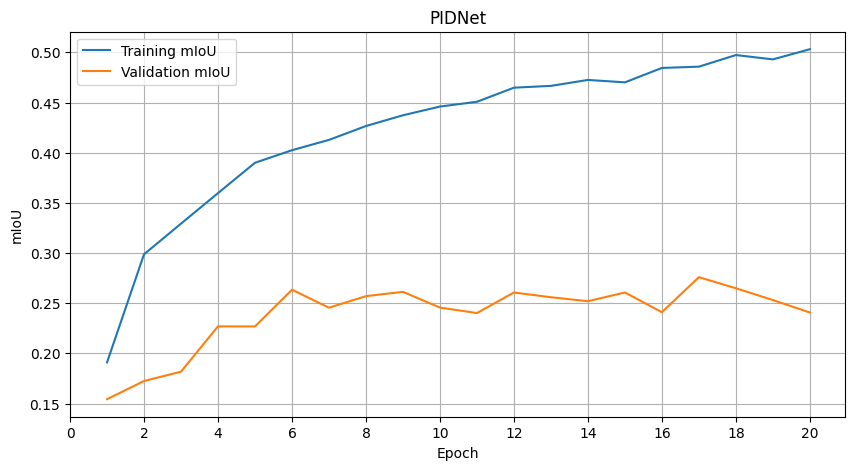

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_train_miou, label='Training mIoU')
plt.plot(range(1, num_epochs + 1), epoch_val_miou, label='Validation mIoU')
plt.xlabel('Epoch')
plt.ylabel('mIoU')
plt.title('PIDNet')
plt.legend()
plt.grid(True)
plt.xticks(range(0, num_epochs + 2, 2))
plt.show()

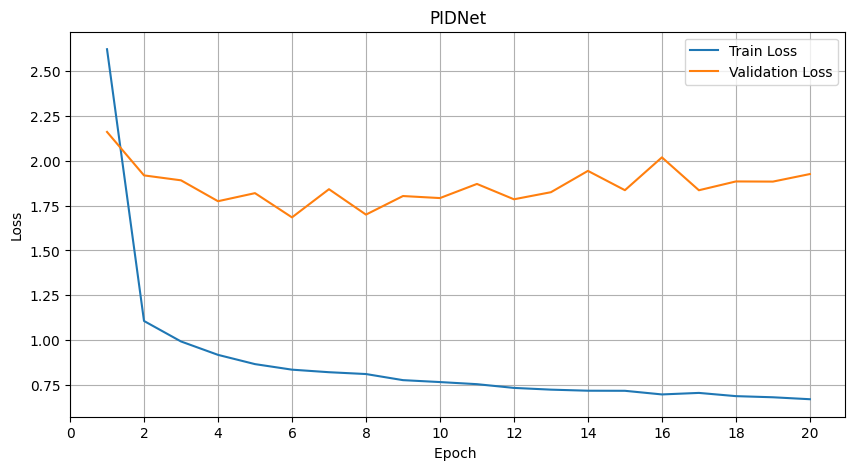

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), epoch_train_loss, label="Train Loss")
plt.plot(range(1, num_epochs + 1), epoch_val_loss, label="Validation Loss")
plt.xlabel("Epoch ")
plt.ylabel("Loss")
plt.title("PIDNet")
plt.legend()
plt.grid(True)
plt.xticks(range(0, num_epochs + 2, 2))
plt.show()

In [14]:
# Download the Test Image
!mkdir -p LoveDA/Test/Rural

#!wget https://github.com/aliabbasi2000/Real-time-Domain-Adaptation-in-Semantic-Segmentation/blob/280a73361b252434aa65f9602b4b51714d092015/data/LoveDA/Test/Rural/4196.png -O LoveDA/Test/Rural/4196.png


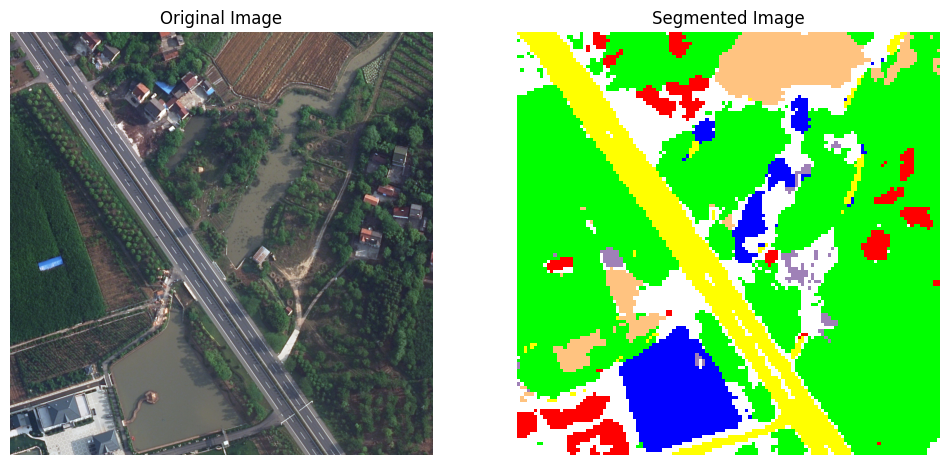

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Define label colors (R, G, B) for each class
class_labels = ["background", "building", "road", "water", "barren", "forest", "agriculture"]
label_colors = {
    "background": (255, 255, 255),        # White
    "building": (255, 0, 0),             # Red
    "road": (255, 255, 0),               # Yellow
    "water": (0, 0, 255),                # Blue
    "barren": (159, 129, 183),           # Purple
    "forest": (0, 255, 0),               # Green
    "agriculture": (255, 195, 128)       # Peach
}

# Load a single image for segmentation
image_path = "/content/PIDNet/LoveDA/Test/Rural"
image_files = [f for f in os.listdir(image_path) if os.path.isfile(os.path.join(image_path, f)) and not f.startswith('.')]
image_name = image_files[0]
image = Image.open(os.path.join(image_path, image_name)).convert('RGB')

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_image = transform(image).unsqueeze(0).to(device)


model.eval()
with torch.no_grad():
    output = model(input_image)  # Shape: (1, num_classes, H, W)
    output = output[0] 
    preds = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()  # Shape: (H, W)

# Create a segmentation map
segmentation_map = np.zeros((preds.shape[0], preds.shape[1], 3), dtype=np.uint8)

for label_index, label_name in enumerate(class_labels):
    color = label_colors[label_name]
    segmentation_map[preds == label_index] = color

# Visualize the original image and segmentation map
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(segmentation_map)
plt.title("Segmented Image")
plt.axis("off")

plt.show()

#TEST5 Discriminator LR =0.00001

Validation Loss: 2.0001, Validation mIoU: 0.2914

#TEST4 Discriminator LR = 0.001

Validation Loss: 1.7328, Validation mIoU: 0.2886

#TEST3 Discriminator LR = 0.0001

Validation Loss: 1.9407, Validation mIoU: 0.2807

Class-wise IoU:
  background: 0.5196
  building: 0.3947
  road: 0.2539
  water: 0.3398
  barren: 0.1371
  forest: 0.0993
  agriculture: 0.2797

#test1

criterion_gan = nn.BCELoss()

criterion_segmentation = nn.CrossEntropyLoss()

Validation Loss: 1.8695, Validation mIoU: 0.2581
